### 5.1 Whole Slide Scoring - Tissue Area WSI Segmentation

Tissue segmentation against the slide background was performed in the lightness-chroma-hue (LCH) colorspace using a specific colormask for each WSI. Morphological opening and closing operations were performed to smooth the binary masks, and the tissue areas were the pixel sum of refined masks.

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pyvips as Vips
import cv2

In [2]:
RAW_DIR = '/home/ziqi/Desktop/data/plaques_WSIs/'
CSV_DIR = '/home/ziqi/Desktop/WSI_CERAD.csv'
SAVE_DIR = '/home/ziqi/Desktop/'

In [ ]:
file = pd.read_csv(CSV_DIR)
raw_imagedir = list(file['WSI_ID'])

In [6]:
# from https://github.com/jcupitt/libvips/blob/master/doc/Examples.md

NP_DTYPE_TO_VIPS_FORMAT = {
        np.dtype('int8'): Vips.BandFormat.CHAR,
        np.dtype('uint8'): Vips.BandFormat.UCHAR,
        np.dtype('int16'): Vips.BandFormat.SHORT,
        np.dtype('uint16'): Vips.BandFormat.USHORT,
        np.dtype('int32'): Vips.BandFormat.INT,
        np.dtype('float32'): Vips.BandFormat.FLOAT,
        np.dtype('float64'): Vips.BandFormat.DOUBLE
    }

VIPS_FORMAT_TO_NP_DTYPE = {v:k for k, v in NP_DTYPE_TO_VIPS_FORMAT.items()}

def array_vips(vips_image, verbose=False):
    # dtype = np.dtype('u{}'.format(vips_image.BandFmt.bit_length() + 1))
    dtype = VIPS_FORMAT_TO_NP_DTYPE[vips_image.format]
    if verbose:
        print(dtype, vips_image.height, vips_image.width, vips_image.bands)
    return (np.fromstring(vips_image.write_to_memory(), dtype=dtype) #np.uint8)
             .reshape(vips_image.height, vips_image.width, vips_image.bands))
    

def show_vips(vips_image, ax=plt, show=True, verbose=False):
    if not isinstance(vips_image, Vips.Image):
        return -1
    
    im_np = array_vips(vips_image)
    if verbose:
        print(im_np.shape)
    if vips_image.bands == 1:
        ax.imshow(im_np.squeeze()/np.max(im_np), cmap=plt.get_cmap('gist_ncar'))
    elif vips_image.bands == 2:
        im_np = im_np[:,:,1]
        ax.imshow(im_np/np.max(im_np), cmap=plt.get_cmap('gray'))
    else:
        ax.imshow(im_np)
    if show:
        plt.show()
    
    
def image_fields_dict(im_with_fields):
    return {k:im_with_fields.get(k) 
            for k in im_with_fields.get_fields() 
            if im_with_fields.get_typeof(k)}

In [7]:
def opening(mask,
            iterations=1,
            kernel=[[128, 128, 255, 128, 128],
                    [128, 128, 255, 128, 128],
                    [255, 255, 255, 255, 255],
                    [128, 128, 255, 128, 128],
                    [128, 128, 255, 128, 128]]):
    """
    mask is a Vips Image
    """
    for iteration in range(iterations):
        mask = mask.erode(kernel)
        mask = mask.dilate(kernel)
    return mask

def closing(mask,
            iterations=1,
            kernel=[[128, 128, 255, 128, 128],
                    [128, 128, 255, 128, 128],
                    [255, 255, 255, 255, 255],
                    [128, 128, 255, 128, 128],
                    [128, 128, 255, 128, 128]]):
    """
    mask is a Vips Image
    """
    for iteration in range(iterations):
        mask = mask.dilate(kernel)
        mask = mask.erode(kernel)
    return mask

def mask_background(img,
                    lightness=[-0.1,9999.],
                     chroma=[6.0, 20.],
                     hue=[-0.1,9999.],
                    chroma_thresh = 1):
    """
    img is a Vips Image
    """
#     mask = img.colourspace('VIPS_INTERPRETATION_LCH')[1] > chroma_thresh
    
    im_colorspace  = img.colourspace('VIPS_INTERPRETATION_LCH')
    
    lightness_mask = (im_colorspace[0] > lightness[0]) & \
                     (im_colorspace[0] < lightness[1])
    
    chroma_mask    = (im_colorspace[1] > chroma[0]) & \
                     (im_colorspace[1] < chroma[1])

    hue_mask       = (im_colorspace[2] > hue[0]) & \
                     (im_colorspace[2] < hue[1])        
            
    mask = lightness_mask & chroma_mask & hue_mask
    
    mask = closing(mask, iterations=2)
    mask = opening(mask, iterations=1)
    return mask

In [8]:
LARGE_KERNEL= [[128, 128, 255, 128, 128],
               [128, 128, 255, 128, 128],
               [255, 255, 255, 255, 255],
               [128, 128, 255, 128, 128],
               [128, 128, 255, 128, 128]]

In [9]:
area = []

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


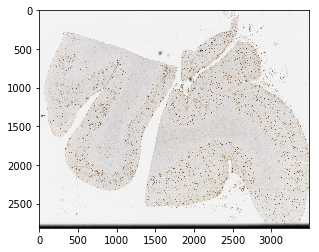

In [10]:
index = 0
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


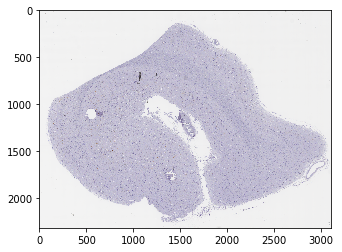

In [12]:
index = 1
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


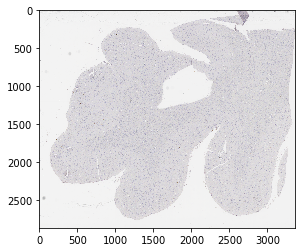

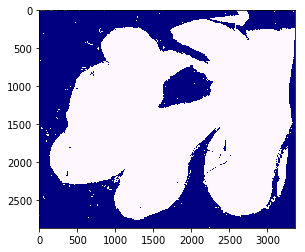

In [13]:
index = 2
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


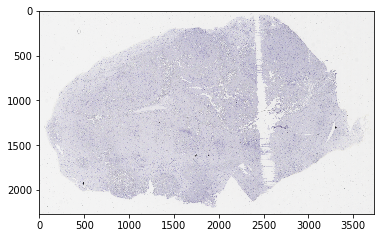

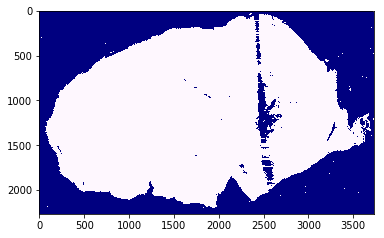

In [14]:
index = 3
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


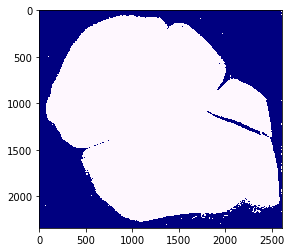

In [15]:
index = 4
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


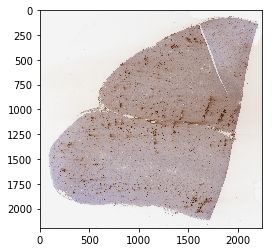

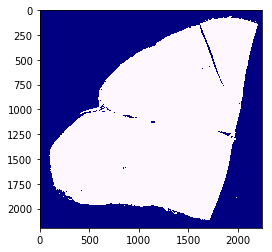

In [16]:
index = 5
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[0.,79.],
                             chroma=[0., 3500.],
                             hue=[0.,390.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

In [17]:
index = 6
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


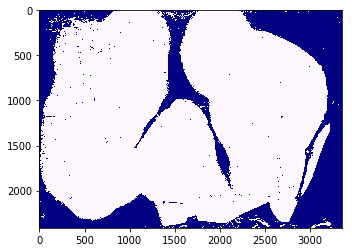

In [18]:
index = 7
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[10.,88.5],
                             chroma=[0.2, 100.],
                             hue=[30.,390.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


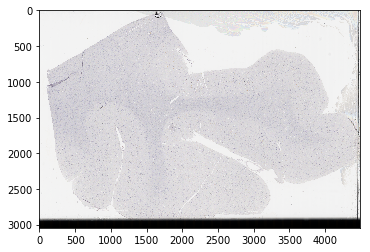

In [19]:
index = 8
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,88.5],
                             chroma=[0.2, 30.],
                             hue=[80.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4129-2_AB.svs (2730, 3983, 4)


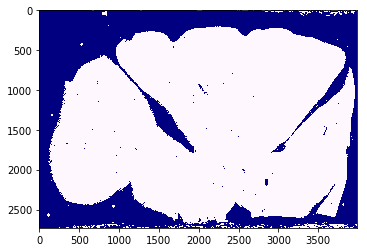

In [20]:
index = 9
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[50.,89.],
                             chroma=[0.2, 200.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


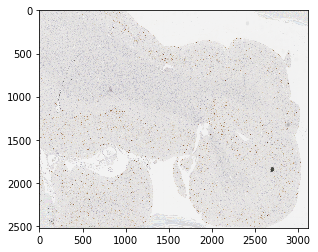

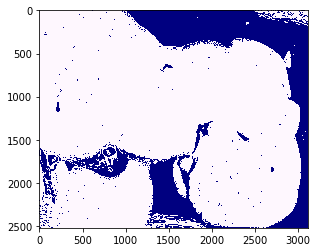

In [21]:
index = 10
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,91.],
                             chroma=[0.2, 200.],
                             hue=[10.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


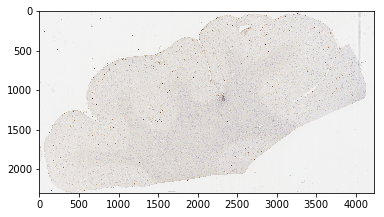

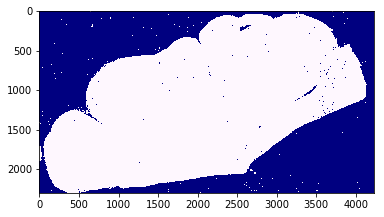

In [22]:
index = 11
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


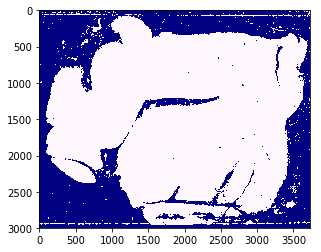

In [23]:
index = 12
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


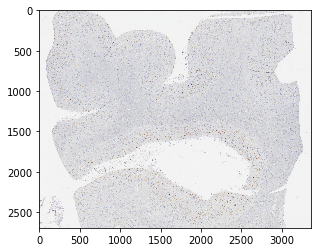

In [24]:
index = 13
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


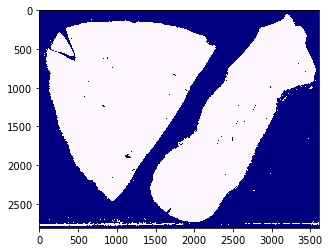

In [25]:
index = 14
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,87.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


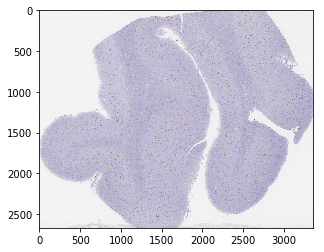

In [26]:
index = 15
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,85.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


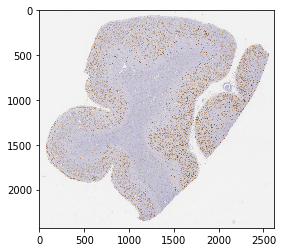

In [27]:
index = 16
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 20.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


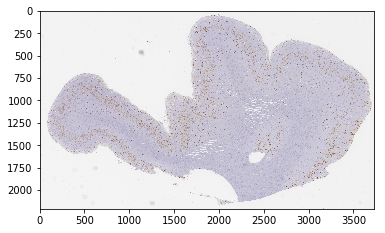

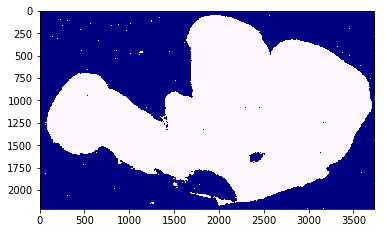

In [28]:
index = 17
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.1, 200.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

In [29]:
index = 18
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[50.,99.],
                             chroma=[1.2, 25.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4974-02_AB17-24.svs (2166, 3236, 4)


/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


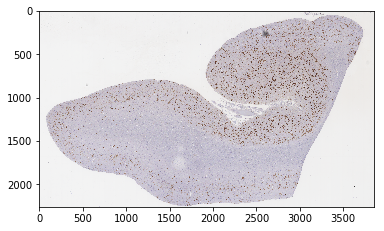

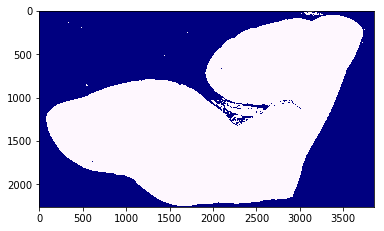

In [30]:
index = 19
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[10.,89.],
                             chroma=[0.2, 200.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA5005-02_AB.svs (2718, 3236, 4)


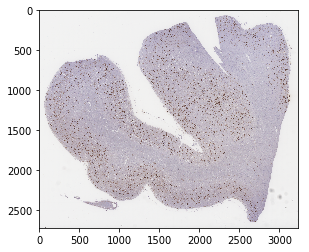

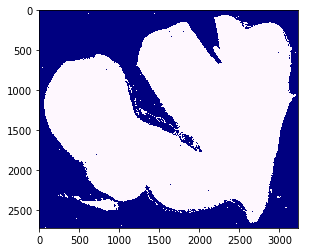

In [31]:
index = 20
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,99.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


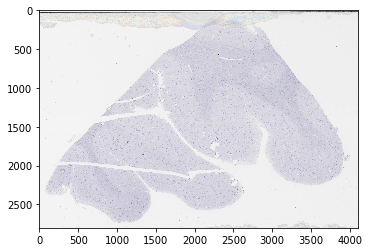

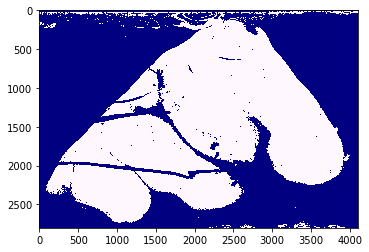

In [32]:
index = 21
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30., 88.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4156-2_AB.svs (5719, 9212, 4)


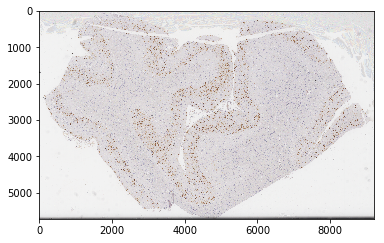

In [33]:
index = 22
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,88],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum()/4)

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4053-02_AB.svs (5794, 8216, 4)


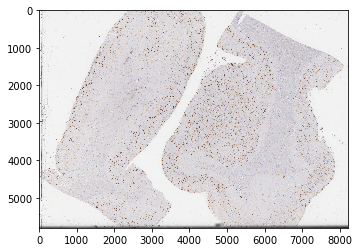

In [34]:
index = 23
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,96.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum()/4)

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4133_2_AB.svs (2882, 3921, 4)


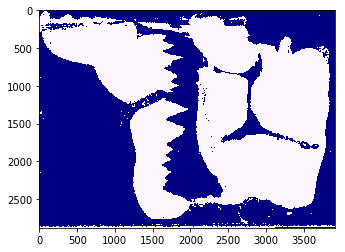

In [35]:
index = 24
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,99.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


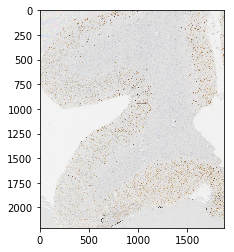

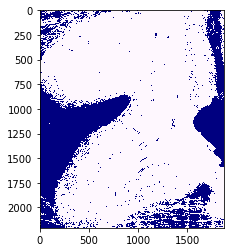

In [36]:
index = 25
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,90.],
                             chroma=[0.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


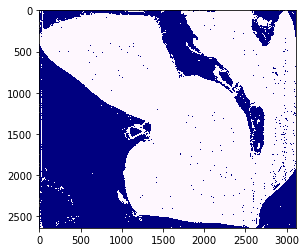

In [37]:
index = 26
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,95.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4167-2_AB.svs (2868, 3797, 4)


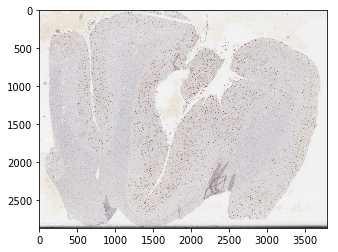

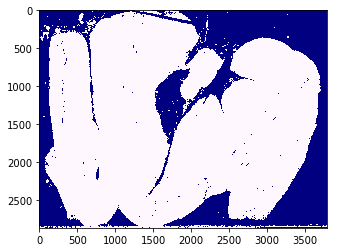

In [38]:
index = 27
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


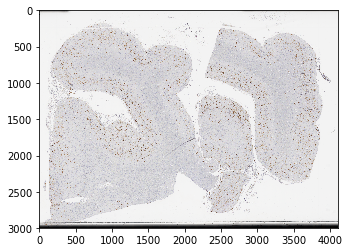

In [39]:
index = 28
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,88.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


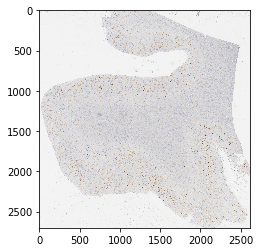

In [40]:
index = 29
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,93.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


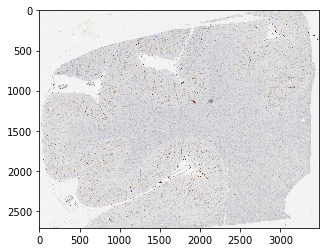

In [41]:
index = 30
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,92.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


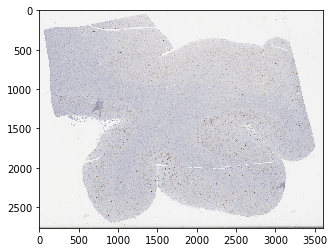

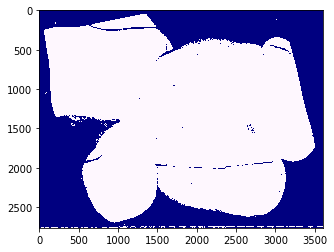

In [42]:
index = 31
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4853-02_AB17-24.svs (2329, 1742, 4)


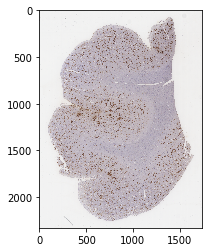

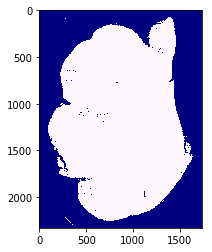

In [43]:
index = 32
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


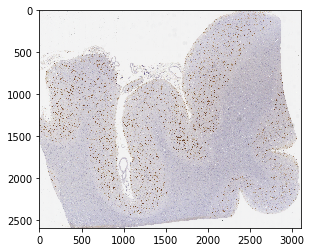

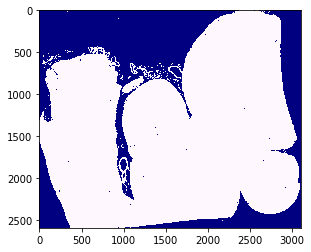

In [44]:
index = 33
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


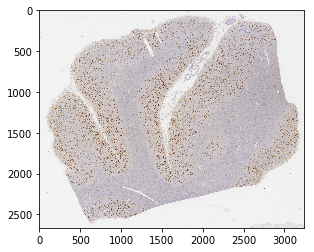

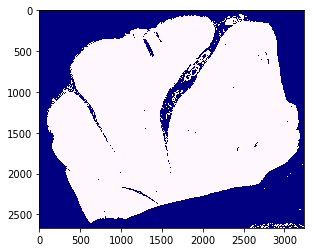

In [45]:
index = 34
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


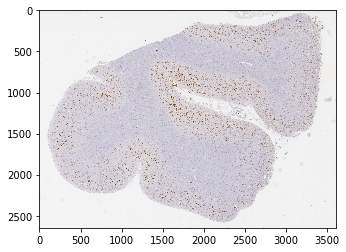

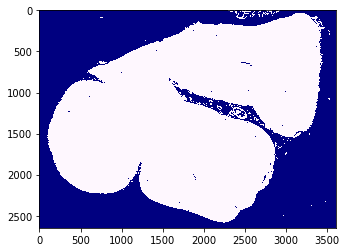

In [46]:
index = 35
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


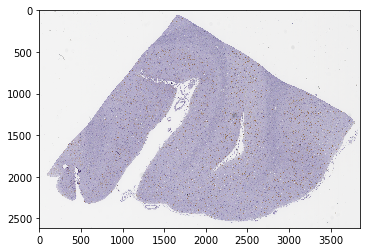

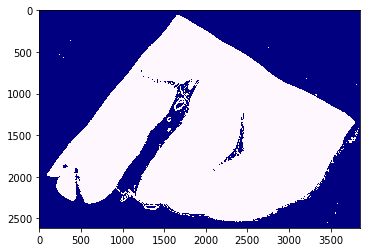

In [47]:
index = 36
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


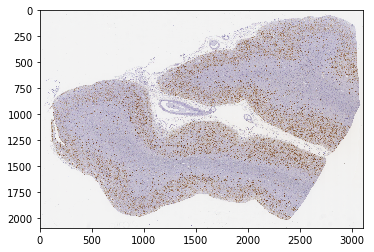

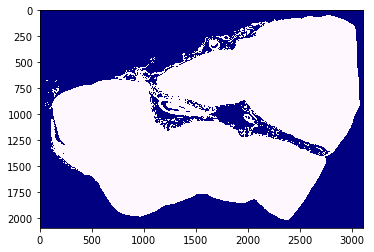

In [48]:
index = 37
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4953-02_AB17-24.svs (2204, 2552, 4)


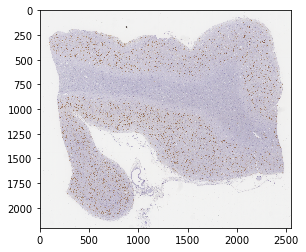

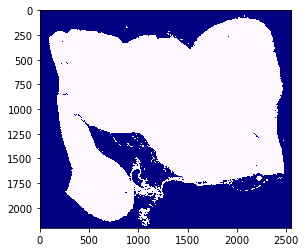

In [49]:
index = 38
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4954-02_AB17-24.svs (5136, 8216, 4)


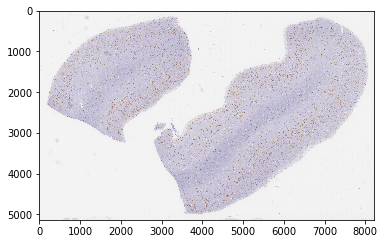

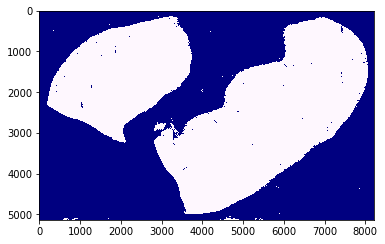

In [50]:
index = 39
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum()/4)

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


NA4964-02_AB17-24.svs (2137, 2925, 4)


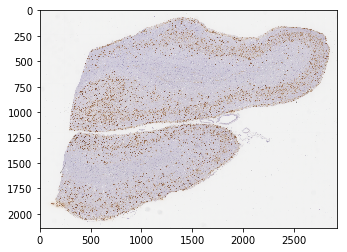

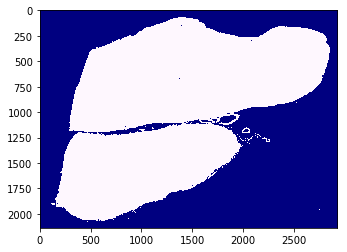

In [51]:
index = 40
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=3)
im = array_vips(img)
print(image, im.shape)

mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

/home/ziqi/miniconda3/envs/pyvips/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


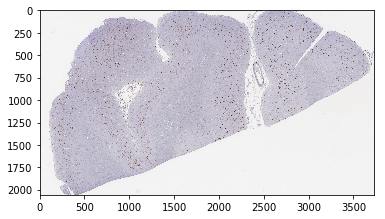

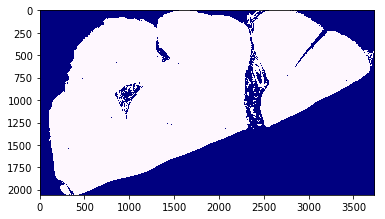

In [52]:
index = 41
CHROMA_THRESHOLD = 2
image = raw_imagedir[index]+'.svs'
img = Vips.Image.new_from_file(RAW_DIR + image, level=2)
mask = mask_background(img, lightness=[30.,89.],
                             chroma=[1.2, 400.],
                             hue=[30.,370.],)
show_vips(img)
show_vips(mask)

mask_array = array_vips(mask)
area.append((mask_array>0).sum())

In [55]:
file['Area'] = area
file.to_csv(SAVE_DIR+'WSI_CERAD.csv', index=False)